# Augmentation을 시도해보자!

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import pandas as pd

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# DataLoad

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

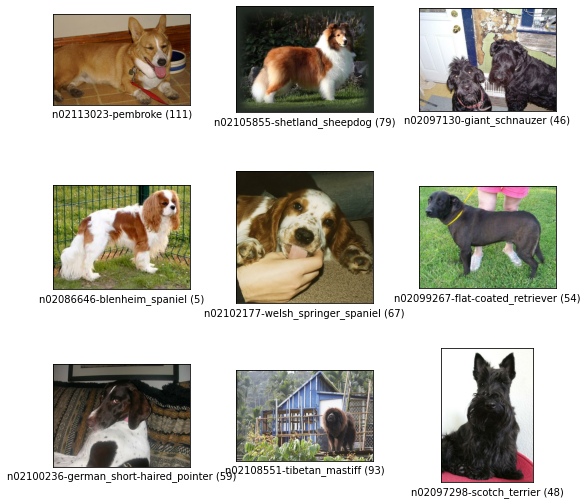

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

# Base Augmentation

In [5]:
#이미지 변환 전처리 함수

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    
    return tf.cast(image, tf.float32) / 255., label   #normalizing

#Argumentation 랜덤 적용 - flip,brightness
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label


#데이터 가공 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  #기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       #augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [6]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

# CutMix

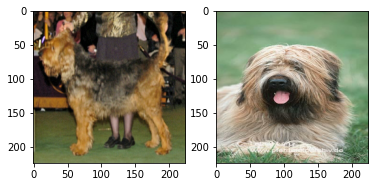

In [7]:

import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [8]:
#이미지a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    
    #image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    #get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    #clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(125, shape=(), dtype=int32) tf.Tensor(201, shape=(), dtype=int32)
y :  tf.Tensor(108, shape=(), dtype=int32) tf.Tensor(195, shape=(), dtype=int32)


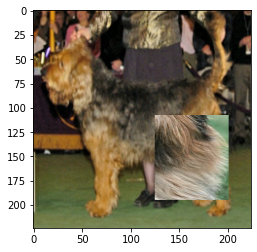

In [9]:
#이미지 a에서 바운딩 박스 바깥 영역, 이미지 b에서 바운딩 박스 안쪽 영역을 합치는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    #image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    
    #image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    
    #image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.numpy())
plt.show()

In [10]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.86822385,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [11]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

# MixUp

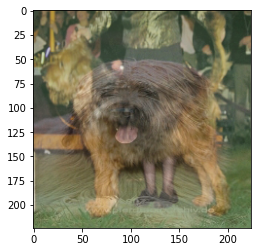

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.6060146 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.3939854 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [12]:
# function for mixup
num_classes = ds_info.features["label"].num_classes
num_classes


def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [13]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

# Dataset

In [14]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [15]:
# 배치 단위로 데이터셋을 정렬 후 CutMix와 Mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [16]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# Model

In [17]:
resnet50_default = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [19]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [20]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 학습

In [21]:
EPOCH = 20  # Augemtation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
resnet50_default.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [22]:
history_resnet50_default = resnet50_default.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 360s 441ms/step - loss: 3.2296 - accuracy: 0.2754 - val_loss: 3.3180 - val_accuracy: 0.2267
Epoch 2/20
750/750 [==============================] - 331s 442ms/step - loss: 0.9534 - accuracy: 0.7335 - val_loss: 1.1204 - val_accuracy: 0.6740
Epoch 3/20
750/750 [==============================] - 332s 442ms/step - loss: 0.3532 - accuracy: 0.9118 - val_loss: 0.9857 - val_accuracy: 0.7122
Epoch 4/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0940 - accuracy: 0.9884 - val_loss: 0.8976 - val_accuracy: 0.7425
Epoch 5/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0318 - accuracy: 0.9987 - val_loss: 0.9180 - val_accuracy: 0.7417
Epoch 6/20
750/750 [==============================] - 331s 442ms/step - loss: 0.0180 - accuracy: 0.9997 - val_loss: 0.9292 - val_accuracy: 0.7411
Epoch 7/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9478 -

In [23]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 337s 442ms/step - loss: 3.2760 - accuracy: 0.2627 - val_loss: 2.9137 - val_accuracy: 0.2868
Epoch 2/20
750/750 [==============================] - 330s 440ms/step - loss: 1.1014 - accuracy: 0.6784 - val_loss: 1.1535 - val_accuracy: 0.6597
Epoch 3/20
750/750 [==============================] - 331s 441ms/step - loss: 0.5951 - accuracy: 0.8366 - val_loss: 1.1652 - val_accuracy: 0.6694
Epoch 4/20
750/750 [==============================] - 331s 441ms/step - loss: 0.3318 - accuracy: 0.9177 - val_loss: 1.1128 - val_accuracy: 0.6901
Epoch 5/20
750/750 [==============================] - 331s 441ms/step - loss: 0.1725 - accuracy: 0.9626 - val_loss: 1.0273 - val_accuracy: 0.7148
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0923 - accuracy: 0.9864 - val_loss: 1.0460 - val_accuracy: 0.7098
Epoch 7/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0569 - accuracy: 0.9908 - val_loss: 0.9780 -

In [24]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 339s 444ms/step - loss: 4.3627 - accuracy: 0.1146 - val_loss: 3.9597 - val_accuracy: 0.1288
Epoch 2/20
750/750 [==============================] - 332s 443ms/step - loss: 3.0732 - accuracy: 0.3933 - val_loss: 1.6803 - val_accuracy: 0.5415
Epoch 3/20
750/750 [==============================] - 333s 444ms/step - loss: 2.7079 - accuracy: 0.5118 - val_loss: 1.3835 - val_accuracy: 0.6177
Epoch 4/20
750/750 [==============================] - 333s 444ms/step - loss: 2.4635 - accuracy: 0.5837 - val_loss: 1.1901 - val_accuracy: 0.6702
Epoch 5/20
750/750 [==============================] - 333s 444ms/step - loss: 2.3264 - accuracy: 0.6328 - val_loss: 1.2254 - val_accuracy: 0.6618
Epoch 6/20
750/750 [==============================] - 333s 444ms/step - loss: 2.2279 - accuracy: 0.6575 - val_loss: 1.4604 - val_accuracy: 0.6172
Epoch 7/20
750/750 [==============================] - 332s 443ms/step - loss: 2.1070 - accuracy: 0.6933 - val_loss: 1.2169 -

In [25]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 339s 444ms/step - loss: 4.2731 - accuracy: 0.1300 - val_loss: 3.7597 - val_accuracy: 0.1538
Epoch 2/20
750/750 [==============================] - 332s 443ms/step - loss: 2.9587 - accuracy: 0.4427 - val_loss: 1.4271 - val_accuracy: 0.5967
Epoch 3/20
750/750 [==============================] - 333s 444ms/step - loss: 2.6626 - accuracy: 0.5460 - val_loss: 1.3883 - val_accuracy: 0.6073
Epoch 4/20
750/750 [==============================] - 332s 443ms/step - loss: 2.4698 - accuracy: 0.6242 - val_loss: 1.2865 - val_accuracy: 0.6425
Epoch 5/20
750/750 [==============================] - 333s 444ms/step - loss: 2.2830 - accuracy: 0.6936 - val_loss: 1.3894 - val_accuracy: 0.6219
Epoch 6/20
750/750 [==============================] - 332s 443ms/step - loss: 2.1728 - accuracy: 0.7353 - val_loss: 1.2765 - val_accuracy: 0.6519
Epoch 7/20
750/750 [==============================] - 333s 444ms/step - loss: 2.0758 - accuracy: 0.7733 - val_loss: 1.2076 -

# 결과 시각화

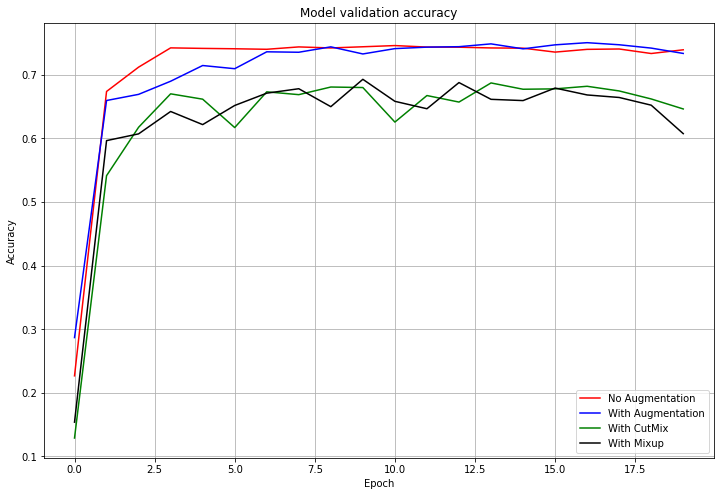

In [26]:
plt.figure(figsize=(12, 8))

plt.plot(history_resnet50_default.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

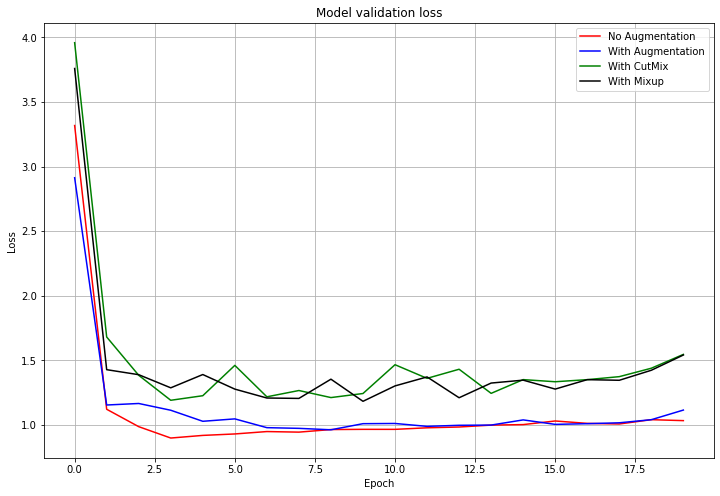

In [27]:
plt.figure(figsize=(12, 8))

plt.plot(history_resnet50_default.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

# 결과 및 해석
- 정확도 그래프를 보면 CutMix과 Mixup이 기본 Augmentation으로 했을 때보다 더 낮다.
- Loss 그래프를 봐도 CutMix와 Mixup방식이 더 안 좋은 것을 알 수 있다.
- 아마도 다른 요인이 있을 것 같은데, 그 점까지는 파악하지 못 했다.